1) скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention

2) поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.

3) сделать разбиение набора данных не тренировочную и тестовую выборки

4) сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)

5) провести uplift-моделирование 3 способами:

одна модель с признаком коммуникации (S-learner)

модель с трансформацией таргета

вариант с двумя независимыми моделями

6) в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% 3 моделей

7) *для модели S-learner построить зависимость таргета (конверсии - поле conversion) от значения uplift:

сделать прогноз и получить uplift для тестовой выборки

отсортировать тестовую выборку по uplift по убыванию

разбить на децили (pandas qcut вам в помощь)

для каждого дециля посчитать среднюю conversion

In [60]:
import numpy as np
import pandas as pd

скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention

In [61]:
df = pd.read_csv('data.csv')
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0


поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.

In [62]:
df.rename(columns={'conversion':'target'}, inplace = True)

In [63]:
df.rename(columns={'offer':'treatment'}, inplace = True)

In [64]:
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0


In [65]:
df['treatment'].unique()

array(['Buy One Get One', 'No Offer', 'Discount'], dtype=object)

In [66]:
mapping = {'Buy One Get One' : 1, 
           'No Offer' : 0, 
           'Discount' : 1}

In [67]:
df['treatment'] = df['treatment'].map(mapping)

In [68]:
df['treatment'].unique()

array([1, 0], dtype=int64)

сделать разбиение набора данных не тренировочную и тестовую выборки

In [69]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', axis=1), 
                                                    df['target'], random_state=0)

сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)

In [70]:
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

In [71]:
X_train.head(3)

,recency,history,used_discount,used_bogo,is_referral,treatment,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
1098,8,63.58,1,0,1,1,0,1,0,0,1,0
13764,3,395.35,1,0,1,1,0,1,0,0,0,1
45116,4,1307.99,1,1,1,1,1,0,0,0,1,0


провести uplift-моделирование 3 способами:

одна модель с признаком коммуникации (S-learner)


In [81]:
from sklift.models import SoloModel, TwoModels, ClassTransformation
from sklift.metrics import uplift_at_k

from sklearn.ensemble import GradientBoostingClassifier

In [97]:
treat_train = X_train['treatment']
treat_test = X_test['treatment']
models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': []
}

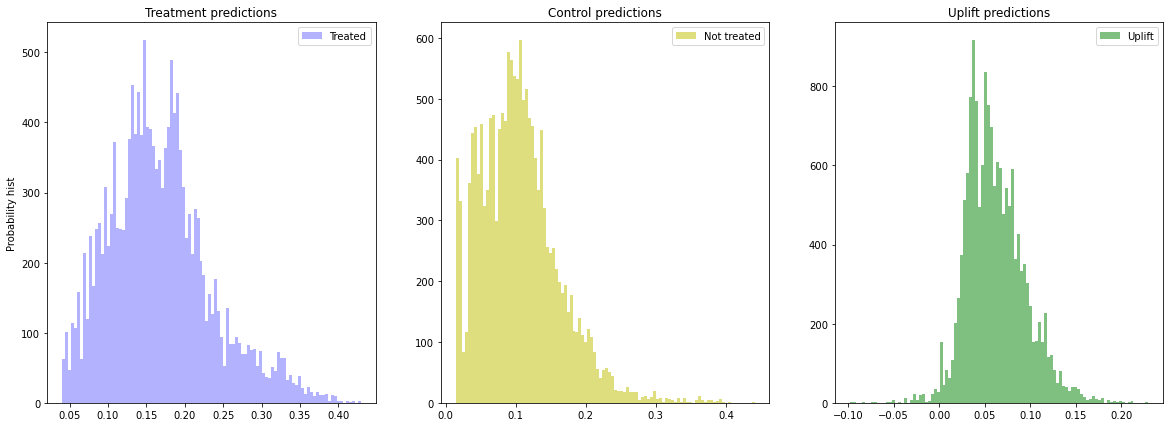

In [98]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

# sklift поддерживает любые модели, 
# которые удовлетворяют соглашениями scikit-learn
# Для примера воспользуемся catboost
from catboost import CatBoostClassifier


sm = SoloModel(
    CatBoostClassifier(iterations=20, random_state=42, silent=True)
)

sm = sm.fit(X_train, y_train, treat_train)

uplift_sm = sm.predict(X_test)

sm_score_1 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.1)
sm_score_2 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.2)

models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score_1)
models_results['uplift@20%'].append(sm_score_2)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [99]:
# С той же легкостью можно обратиться к обученной модели.
# Например, чтобы построить важность признаков:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,is_referral,18.155308
1,treatment,17.942577
2,used_bogo,12.768646
3,recency,12.061491
4,history,11.675302
5,used_discount,9.292318
6,zip_code_Rural,6.891349
7,channel_Phone,4.794693
8,channel_Web,3.307677
9,zip_code_Surburban,1.397088


модель с трансформацией таргета


In [100]:
from sklift.models import ClassTransformation


ct = ClassTransformation( CatBoostClassifier(iterations=20, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train)

uplift_ct = ct.predict(X_test)

ct_score_1 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.1)
ct_score_2 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.2)

models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score_1)
models_results['uplift@20%'].append(ct_score_2)

<ipython-input-100-7d65d694812a>:5: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  ct = ct.fit(X_train, y_train, treat_train)


In [101]:
ct_score

0.17068272146032643


вариант с двумя независимыми моделями

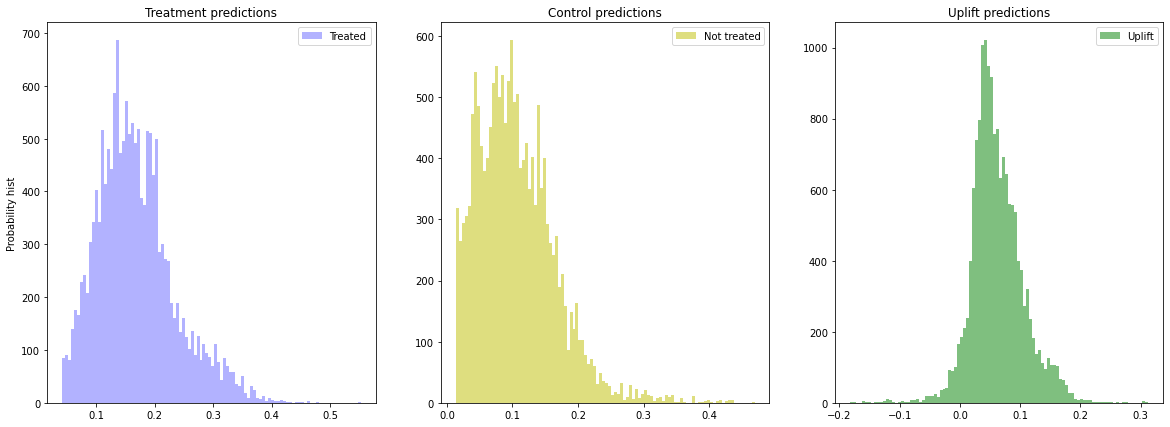

In [102]:
from sklift.models import TwoModels


tm = TwoModels(
    CatBoostClassifier(iterations=20, random_state=42, silent=True),
    CatBoostClassifier(iterations=20, random_state=42, silent=True),
    method='vanilla'  # независимые модели
)
tm = tm.fit(
    X_train, y_train, treat_train
)

uplift_tm = tm.predict(X_test)

tm_score_1 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.1)
tm_score_2 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.2)

models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score_1)
models_results['uplift@20%'].append(tm_score_2)
plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% 3 моделей

In [106]:
pd.DataFrame(data=models_results).sort_values('uplift@20%', ascending=False).set_index('approach')


,uplift@10%,uplift@20%
approach,,
ClassTransformation,0.233002,0.192543
SoloModel,0.067078,0.074294
TwoModels,0.050033,0.062890
